## Option 1: Simple keyword search.

Just split documents into tokens and match queries with them.

In [52]:
import re

# scikit-learn imports.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
import faiss

import numpy as np

import time
import math
from collections import defaultdict

import matplotlib.pyplot as plt

In [53]:
docs = [
    "Bonjour, je m'appelle Marie",   # French
    "Hello, my name is John",        # English
    "Hola, me llamo Carlos",         # Spanish
    "Hallo, ich heiße Anna",         # German
    "Ciao, mi chiamo Luca"           # Italian
]

In [54]:
def keyword_search(query, docs):
    query_tokens = set(re.findall(r"\w+", query.lower()))
    results = []
    for i, doc in enumerate(docs):
        doc_tokens = set(re.findall(r"\w+", doc.lower()))
        overlap = len(query_tokens & doc_tokens)
        if overlap > 0:
            results.append((i, overlap))
    results.sort(key=lambda x: -x[1])  # sort by score
    return [docs[i] for i, _ in results]


In [55]:
# Example
print("Keyword Search Results:")
print(keyword_search("name John", docs))

Keyword Search Results:
['Hello, my name is John']


### Option 2: TF-IDF Vectorization (scikit-learn)

In [56]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

In [57]:
def tfidf_search(query, top_k=2):
    query_vec = vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    return [(docs[i], scores[i]) for i in top_indices]

In [58]:
# Example
print("TF-IDF Search Results:")
print(tfidf_search("name John"))


TF-IDF Search Results:
[('Hello, my name is John', 0.632455532033676), ('Ciao, mi chiamo Luca', 0.0)]


### Keyword vs. Semantic Search

In [59]:
# Multilingual dataset
docs = [
    "Bonjour, je m'appelle Marie",   # French
    "Hello, my name is John",        # English
    "Hola, me llamo Carlos",         # Spanish
    "Hallo, ich heiße Anna",         # German
    "Ciao, mi chiamo Luca"           # Italian
]

In [60]:
# ---------------------------
# 1. Keyword Search (TF-IDF)
# ---------------------------
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

In [61]:
def keyword_search(query, top_k=2):
    query_vec = vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    return [(docs[i], scores[i]) for i in top_indices]

In [62]:
# ---------------------------
# 2. Semantic Search (Dense Index with FAISS)
# ---------------------------
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(docs, convert_to_numpy=True, normalize_embeddings=True)
d = embeddings.shape[1]

/Users/himanshusharma/anaconda3/envs/cross-lingual-semantic-search/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [63]:
# Dense FAISS index
index_dense = faiss.IndexFlatIP(d)
index_dense.add(embeddings)

In [64]:
def semantic_search(query, top_k=2):
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    D, I = index_dense.search(query_vec, k=top_k)
    return [(docs[idx], float(D[0][j])) for j, idx in enumerate(I[0])]

In [65]:
# ---------------------------
# 3. Test Queries
# ---------------------------
queries = [
    "My name is Pedro",      # English quer
    "Me llamo Pedro",        # Spanish query
    "Je m'appelle Pierre"    # French query
]

In [31]:
for q in queries:
    print("="*50)
    print(f"🔎 Query: {q}")
    
    print("\nKeyword Search Results:")
    for doc, score in keyword_search(q, top_k=2):
        print(f"  {doc}  (score={score:.4f})")
    
    print("\nSemantic Search Results:")
    for doc, score in semantic_search(q, top_k=2):
        print(f"  {doc}  (similarity={score:.4f})")

🔎 Query: My name is Pedro

Keyword Search Results:
  Hello, my name is John  (score=0.7746)
  Ciao, mi chiamo Luca  (score=0.0000)

Semantic Search Results:
  Hola, me llamo Carlos  (similarity=0.7587)
  Ciao, mi chiamo Luca  (similarity=0.6668)
🔎 Query: Me llamo Pedro

Keyword Search Results:
  Hola, me llamo Carlos  (score=0.7071)
  Ciao, mi chiamo Luca  (score=0.0000)

Semantic Search Results:
  Hola, me llamo Carlos  (similarity=0.7655)
  Ciao, mi chiamo Luca  (similarity=0.6843)
🔎 Query: Je m'appelle Pierre

Keyword Search Results:
  Bonjour, je m'appelle Marie  (score=0.7071)
  Ciao, mi chiamo Luca  (score=0.0000)

Semantic Search Results:
  Bonjour, je m'appelle Marie  (similarity=0.6548)
  Hallo, ich heiße Anna  (similarity=0.6019)


******

## Formal experimental setup.

In [66]:
# ---------- Data ----------
docs = [
    # id, text (multilingual introductions of a person)
    (0, "Bonjour, je m'appelle Marie"),
    (1, "Hello, my name is John"),
    (2, "Hola, me llamo Carlos"),
    (3, "Hallo, ich heiße Anna"),
    (4, "Ciao, mi chiamo Luca"),
    (5, "Me llamo Juan y vivo en Madrid"),
    (6, "Je m'appelle Pierre et j'habite à Paris"),
    (7, "My name is Mary and I live in London"),
    (8, "Ich heiße Johann und wohne in Berlin"),
    (9, "Mi nombre es Pedro y estudio en Barcelona"),
]

In [67]:
# Queries in different languages meaning roughly “my name is X”
queries = {
    "q_en": "My name is Pedro",
    "q_es": "Me llamo Pedro",
    "q_fr": "Je m'appelle Pierre",
    "q_de": "Ich heiße Johann",
    "q_it": "Mi chiamo Luca",
}

In [68]:
# ---------- Ground truth (qrels) ----------
# Mark which doc ids should be relevant for each query (not exhaustive, just enough to evaluate)
# You can extend these as your dataset grows.
qrels = {
    "q_en": {9},                 # “My name is Pedro” ~ doc 9 (Spanish but same meaning)
    "q_es": {9},                 # Spanish query -> doc 9
    "q_fr": {6},                 # French query -> doc 6
    "q_de": {8},                 # German query -> doc 8
    "q_it": {4},                 # Italian query -> doc 4
}

In [69]:
# ---------- Utilities: metrics ----------
def dcg(rels):
    return sum((rel / math.log2(i+2)) for i, rel in enumerate(rels))

def ndcg_at_k(pred, gold, k):
    gains = [1 if d in gold else 0 for d in pred[:k]]
    ideal = sorted(gains, reverse=True)
    return 0.0 if sum(ideal) == 0 else dcg(gains) / dcg(ideal)

def precision_at_k(pred, gold, k):
    hit = sum(1 for d in pred[:k] if d in gold)
    return hit / k

def recall_at_k(pred, gold, k):
    if not gold: return 0.0
    hit = sum(1 for d in pred[:k] if d in gold)
    return hit / len(gold)

def mrr(pred, gold):
    for i, d in enumerate(pred):
        if d in gold:
            return 1.0 / (i+1)
    return 0.0

In [70]:
# ---------- Baseline: Keyword (TF-IDF) ----------
doc_texts = [t for _, t in docs]
doc_ids = [i for i, _ in docs]

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(doc_texts)


In [71]:
def tfidf_search(q, top_k=5):
    qv = tfidf.transform([q])
    scores = cosine_similarity(qv, tfidf_matrix).ravel()
    order = scores.argsort()[::-1][:top_k]
    return [doc_ids[i] for i in order], [float(scores[i]) for i in order]

In [72]:
# ---------- Semantic: Dense embeddings + FAISS (optional if installed) ----------
semantic_available = True
try:
    import faiss
    from sentence_transformers import SentenceTransformer
except Exception as e:
    semantic_available = False

if semantic_available:
    model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
    import numpy as np
    emb = model.encode(doc_texts, convert_to_numpy=True, normalize_embeddings=True)
    dim = emb.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(emb)

    def semantic_search(q, top_k=5):
        qv = model.encode([q], convert_to_numpy=True, normalize_embeddings=True)
        D, I = index.search(qv, k=top_k)
        return [doc_ids[i] for i in I[0]], [float(d) for d in D[0]]
else:
    def semantic_search(q, top_k=5):
        raise RuntimeError("Install sentence-transformers and faiss-cpu to run semantic search.")

In [73]:
# ---------- Evaluation loop ----------
methods = ["keyword"]
if semantic_available:
    methods.append("semantic")

In [74]:
K = 5
results = defaultdict(lambda: defaultdict(list))  # results[method][metric] = list of values
timings = defaultdict(list)

In [75]:
for qid, qtext in queries.items():
    gold = qrels.get(qid, set())

    # Keyword
    t0 = time.time()
    pred_kw, _ = tfidf_search(qtext, top_k=K)
    t1 = time.time()
    timings["keyword"].append(t1 - t0)

    results["keyword"]["P@5"].append(precision_at_k(pred_kw, gold, K))
    results["keyword"]["R@5"].append(recall_at_k(pred_kw, gold, K))
    results["keyword"]["nDCG@5"].append(ndcg_at_k(pred_kw, gold, K))
    results["keyword"]["MRR"].append(mrr(pred_kw, gold))

    # Semantic
    if "semantic" in methods:
        t0 = time.time()
        pred_sem, _ = semantic_search(qtext, top_k=K)
        t1 = time.time()
        timings["semantic"].append(t1 - t0)

        results["semantic"]["P@5"].append(precision_at_k(pred_sem, gold, K))
        results["semantic"]["R@5"].append(recall_at_k(pred_sem, gold, K))
        results["semantic"]["nDCG@5"].append(ndcg_at_k(pred_sem, gold, K))
        results["semantic"]["MRR"].append(mrr(pred_sem, gold))


In [76]:
# ---------- Aggregate + report ----------
def avg(x): return sum(x)/len(x) if x else 0.0


In [77]:
print("\n=== Aggregate Metrics (mean over queries) ===")
for m in methods:
    print(f"\n[{m.upper()}]")
    print(f"P@5     : {avg(results[m]['P@5']):.3f}")
    print(f"R@5     : {avg(results[m]['R@5']):.3f}")
    print(f"nDCG@5  : {avg(results[m]['nDCG@5']):.3f}")
    print(f"MRR     : {avg(results[m]['MRR']):.3f}")
    print(f"Latency : {avg(timings[m])*1000:.1f} ms/query")


=== Aggregate Metrics (mean over queries) ===

[KEYWORD]
P@5     : 0.200
R@5     : 1.000
nDCG@5  : 0.800
MRR     : 0.733
Latency : 1.5 ms/query

[SEMANTIC]
P@5     : 0.200
R@5     : 1.000
nDCG@5  : 0.926
MRR     : 0.900
Latency : 21.2 ms/query


In [78]:
# ---------- Optional: simple per-query printout ----------
print("\n=== Per-Query Top-5 (ids) ===")
for qid, qtext in queries.items():
    print(f"\nQuery {qid}: {qtext}")
    pred_kw, sc_kw = tfidf_search(qtext, top_k=K)
    print("  Keyword :", pred_kw)
    if "semantic" in methods:
        pred_sem, sc_sem = semantic_search(qtext, top_k=K)
        print("  Semantic:", pred_sem)


=== Per-Query Top-5 (ids) ===

Query q_en: My name is Pedro
  Keyword : [1, 7, 9, 8, 5]
  Semantic: [9, 2, 5, 4, 6]

Query q_es: Me llamo Pedro
  Keyword : [2, 5, 9, 8, 6]
  Semantic: [9, 2, 5, 4, 6]

Query q_fr: Je m'appelle Pierre
  Keyword : [6, 0, 8, 9, 5]
  Semantic: [6, 8, 0, 9, 5]

Query q_de: Ich heiße Johann
  Keyword : [8, 3, 9, 7, 5]
  Semantic: [1, 8, 0, 3, 4]

Query q_it: Mi chiamo Luca
  Keyword : [4, 9, 8, 7, 6]
  Semantic: [4, 2, 5, 9, 0]


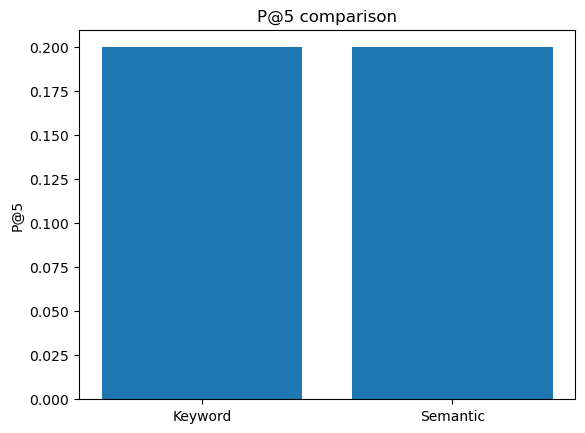

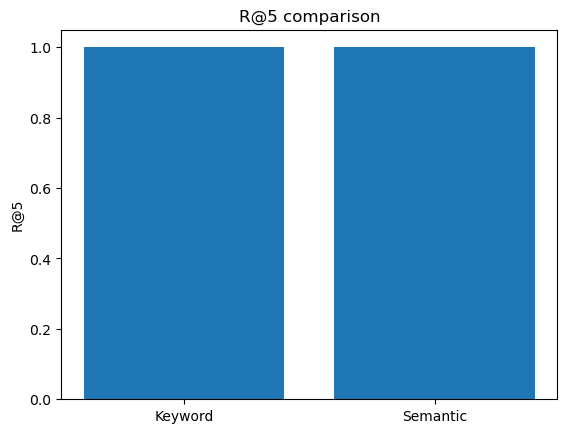

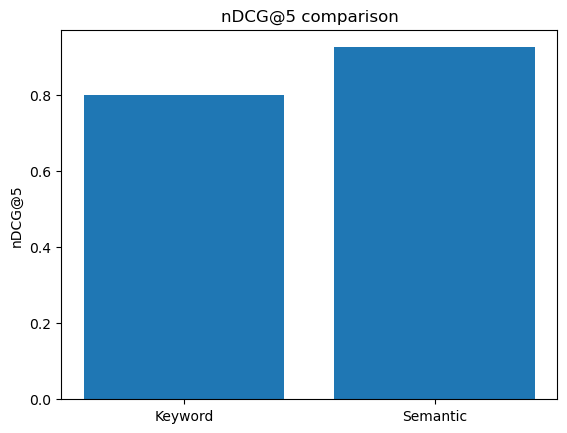

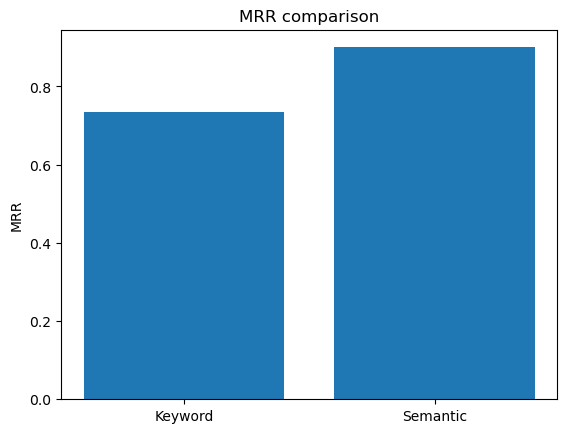

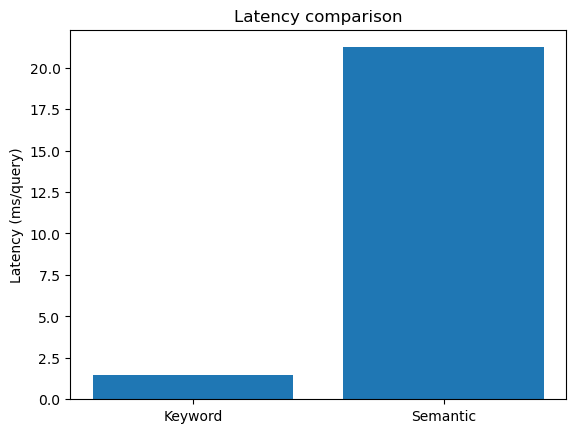

In [79]:
# ---------- Plots (matplotlib; one figure per chart, default colors) ----------
try:
    import matplotlib.pyplot as plt

    for metric in ["P@5", "R@5", "nDCG@5", "MRR"]:
        xs = list(range(len(methods)))
        ys = [avg(results[m][metric]) for m in methods]
        plt.figure()
        plt.bar(xs, ys)                    # no color/style set (per instructions)
        plt.xticks(xs, [m.title() for m in methods])
        plt.ylabel(metric)
        plt.title(f"{metric} comparison")
        plt.show()

    # Latency plot
    xs = list(range(len(methods)))
    ys = [avg(timings[m])*1000 for m in methods]
    plt.figure()
    plt.bar(xs, ys)
    plt.xticks(xs, [m.title() for m in methods])
    plt.ylabel("Latency (ms/query)")
    plt.title("Latency comparison")
    plt.show()

except Exception as e:
    print("Plotting skipped:", e)

******